# Figure 1: Example experiment

In [1]:
import gzip
import pickle

import numpy as np
import matplotlib.pyplot as plt

import hypney.all as hp

import common
from common import powerlaw

# Comment out the line below if you don't have a LaTeX installation
plt.rcParams["text.usetex"] =  True

In [2]:
# Example experiment
similarity = 0.25
mu_unknown = 20
background = powerlaw(mu=mu_unknown, alpha=similarity)
#background.plot_diff_rate()

# Generate one fixed "observed" dataset, then restore
# the random state
seed = 42
state = np.random.get_state()
np.random.seed(seed)
data = background.simulate()
np.random.set_state(state)

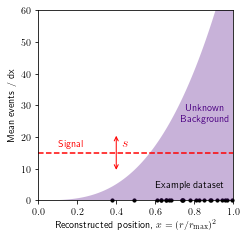

In [3]:
rs = np.linspace(0, 1, 1000)

plt.figure(figsize=(3.5,3.5))

plt.scatter(data, 0 * data, c='k', clip_on=False, s=10)
plt.text(0.6, 4, "Example dataset", c='k')

c = 'indigo'
plt.fill_between(rs, 0, background.diff_rate(rs), 
                 color=c, alpha=0.3, linewidth=0)
plt.text(0.725, 25, 'Unknown\nBackground', c='indigo', ma='center')

mu_sig = 15
y_text = mu_sig + 2
plt.axhline(mu_sig, linestyle='--', c='r')
plt.text(0.1, y_text, 'Signal', c='r')

arrow_x = 0.4
sig_amp = 0.4
plt.annotate("", xy=(arrow_x, mu_sig * (1 - sig_amp)), 
             xytext=(arrow_x, mu_sig * (1 + sig_amp)),
             arrowprops=dict(arrowstyle='<->', color='r'))
plt.text(arrow_x + 0.03, y_text, "$s$", c='r', fontsize=14)

plt.ylabel("Mean events / dx")
plt.ylim(0, 60)

plt.xlabel("Reconstructed position, $x = (r / r_\mathrm{max})^2$")
plt.xlim(0, 1)

for fmt in ('png', 'pdf'):
    plt.savefig(f'example_experiment.{fmt}', dpi=200, bbox_inches='tight')

### Deficit hawk limit

In [4]:
signal = hp.uniform().fix_except('rate')
stat = hp.AllRegionSimpleHawk(
    signal, 
    signal_only=True, 
    regions_type='left'
    ).with_stored_dist('lr_oneside')
ul = hp.UpperLimit(stat, anchors=hp.DEFAULT_RATE_GRID.tolist())

In [5]:
toy_limits = common.draw_limits(ul, source=background, n_limits=1000)

In [6]:
sens_deficit_hawk = np.mean(toy_limits)
sens_deficit_hawk

6.318448460228252

### Optimum interval limit

In [7]:
stat = hp.YellinCNHawk(
    signal,
    signal_only=True).with_stored_dist('yellin_cn_149max')
# Optimum interval requires CN Monte Carlo table;
# I only computed up to mu ~= 150. More than enough for this example.
mu_clip = hp.DEFAULT_RATE_GRID
mu_clip = mu_clip[(mu_clip > 0.1) & (mu_clip < 150)]
ul = hp.UpperLimit(stat, anchors=mu_clip.tolist())

In [8]:
toy_limits_oi = common.draw_limits(ul, source=background, n_limits=1000)

In [9]:
sens_oi = np.mean(toy_limits_oi)
sens_oi

11.394311341390814

In [10]:
left = np.linspace(1e-5, 1 - 1e-5, 10_000)

f_sig_in = left
f_unknown_in = powerlaw(alpha=similarity).cdf(left)
mu_unknown_in_region = mu_unknown * f_unknown_in

sens_mu = dict()
for poisson_kind in 'regular', 'augmented':
    
    with gzip.open('poisson_sens.pkl.gz', mode='rb') as f:
        poisson_sens = pickle.load(f)[poisson_kind]

    sens_n = poisson_sens['itp'](mu_unknown_in_region)
    sens_mu[poisson_kind] = sens_n / f_sig_in

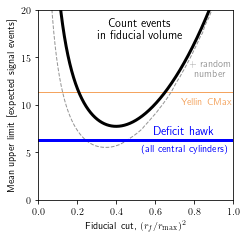

In [11]:
plt.figure(figsize=(3.5, 3.5))

c = 'sandybrown'
plt.axhline(sens_oi, c=c, linewidth=1)
plt.text(0.73, sens_oi / 1.05, s='Yellin CMax', 
         c=c, va='top')

c = plt.cm.Greys(0.5)
plt.plot(left, sens_mu['augmented'], c=c, linestyle='--', linewidth=1)
plt.text(0.77, 13, "+ random \n number", ha='left', c=c, ma='center')

c = 'b'
plt.axhline(sens_deficit_hawk, c=c, linewidth=3)
plt.text(0.75, sens_deficit_hawk * 1.05, s='Deficit hawk', 
         c=c, va='bottom', ha='center', fontsize=12)
plt.text(0.75, sens_deficit_hawk / 1.08, s='(all central cylinders)',
         c=c, va='top', ha='center', fontsize=10)


plt.plot(left, sens_mu['regular'], c='k', linewidth=3)
plt.text(0.3, 17, "Count events\nin fiducial volume",
         ha='left', ma='center', fontsize=12)


plt.ylim(0, 20)
plt.yticks([0, 5, 10, 15, 20])
plt.xlim(0, 1)
plt.ylabel("Mean upper limit [expected signal events]")
plt.xlabel(r"Fiducial cut, $(r_f/r_\mathrm{max})^2$")

for fmt in ('png', 'pdf'):
    plt.savefig(f'fiducial_vs_hawk.{fmt}', dpi=200, bbox_inches='tight')